In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb

In [154]:
# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

# Load MNIST data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28
y_dim = 10



In [171]:

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim, y_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + y_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim, y_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim + y_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out



# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)
        labels_one_hot = F.one_hot(labels.to(torch.int64), num_classes=10).float().to(device)
        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        #real
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        #false
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = c_gen(z, labels_one_hot)
        D_real = c_dis(X_real, labels_one_hot)
        D_fake = c_dis(G_sample.detach(), labels_one_hot)

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = c_gen(z, labels_one_hot)
        D_fake = c_dis(G_sample, labels_one_hot)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        
        random_labels = torch.randint(low=0, high=y_dim, size=(mb_size,)).to(device)# One-hot encode
        c = F.one_hot(random_labels, num_classes=y_dim).float().to(device)  # Shape: [64, 10]
        
        samples = c_gen(z, c).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)




In [172]:
def c_gen(z, c):
    inputs = torch.cat([z, c], 1)
    return G(inputs)
def c_dis(x, c):
    inputs = torch.cat([x, c], 1)
    return D(inputs)
########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim, y_dim).to(device)
D = Discriminator(X_dim, h_dim, y_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)
    
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log: 
    wandb.init(project="group2-conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 100

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


# Inference    
G.load_state_dict(torch.load('checkpoints/G_best.pth'))
G.eval()

save_sample(G, "best", mb_size, Z_dim)

D_loss,▁▁▆▇▇████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆
D_loss_fake,▁▄▆▆▇██████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
D_loss_real,▂▁▁▂▃██████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
G_loss,▇█▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
D_loss,0.6406
D_loss_fake,0.28355
D_loss_real,0.35705
G_loss,2.39615


100%|██████████| 938/938 [00:17<00:00, 54.08it/s]


epoch0; D_loss: 0.0754; G_loss: 5.7626
Saved Best Models at epoch 0 | G_loss: 5.7626


100%|██████████| 938/938 [00:17<00:00, 54.97it/s]


epoch1; D_loss: 0.0381; G_loss: 5.7079
Saved Best Models at epoch 1 | G_loss: 5.7079


100%|██████████| 938/938 [00:16<00:00, 55.30it/s]


epoch2; D_loss: 0.0654; G_loss: 5.6912
Saved Best Models at epoch 2 | G_loss: 5.6912


100%|██████████| 938/938 [00:17<00:00, 54.41it/s]


epoch3; D_loss: 0.1291; G_loss: 5.2618
Saved Best Models at epoch 3 | G_loss: 5.2618


100%|██████████| 938/938 [00:17<00:00, 53.75it/s]


epoch4; D_loss: 0.2005; G_loss: 4.8908
Saved Best Models at epoch 4 | G_loss: 4.8908


100%|██████████| 938/938 [00:17<00:00, 54.03it/s]


epoch5; D_loss: 0.3016; G_loss: 4.9130


100%|██████████| 938/938 [00:16<00:00, 55.28it/s]


epoch6; D_loss: 0.4375; G_loss: 4.2761
Saved Best Models at epoch 6 | G_loss: 4.2761


100%|██████████| 938/938 [00:17<00:00, 54.34it/s]


epoch7; D_loss: 0.5426; G_loss: 3.5454
Saved Best Models at epoch 7 | G_loss: 3.5454


100%|██████████| 938/938 [00:17<00:00, 54.84it/s]


epoch8; D_loss: 0.6536; G_loss: 3.2463
Saved Best Models at epoch 8 | G_loss: 3.2463


100%|██████████| 938/938 [00:17<00:00, 54.81it/s]


epoch9; D_loss: 0.7218; G_loss: 2.9417
Saved Best Models at epoch 9 | G_loss: 2.9417


100%|██████████| 938/938 [00:17<00:00, 54.93it/s]


epoch10; D_loss: 0.7478; G_loss: 2.7322
Saved Best Models at epoch 10 | G_loss: 2.7322


100%|██████████| 938/938 [00:17<00:00, 54.59it/s]


epoch11; D_loss: 0.7813; G_loss: 2.6328
Saved Best Models at epoch 11 | G_loss: 2.6328


100%|██████████| 938/938 [00:17<00:00, 55.14it/s]


epoch12; D_loss: 0.8121; G_loss: 2.4794
Saved Best Models at epoch 12 | G_loss: 2.4794


100%|██████████| 938/938 [00:17<00:00, 55.04it/s]


epoch13; D_loss: 0.8374; G_loss: 2.2915
Saved Best Models at epoch 13 | G_loss: 2.2915


100%|██████████| 938/938 [00:16<00:00, 56.52it/s]


epoch14; D_loss: 0.8296; G_loss: 2.1987
Saved Best Models at epoch 14 | G_loss: 2.1987


100%|██████████| 938/938 [00:17<00:00, 54.66it/s]


epoch15; D_loss: 0.8174; G_loss: 2.1608
Saved Best Models at epoch 15 | G_loss: 2.1608


100%|██████████| 938/938 [00:16<00:00, 57.69it/s]


epoch16; D_loss: 0.8192; G_loss: 2.1945


100%|██████████| 938/938 [00:16<00:00, 55.89it/s]


epoch17; D_loss: 0.8301; G_loss: 2.1035
Saved Best Models at epoch 17 | G_loss: 2.1035


100%|██████████| 938/938 [00:16<00:00, 56.09it/s]


epoch18; D_loss: 0.8259; G_loss: 2.0440
Saved Best Models at epoch 18 | G_loss: 2.0440


100%|██████████| 938/938 [00:17<00:00, 53.87it/s]


epoch19; D_loss: 0.8330; G_loss: 2.0452


100%|██████████| 938/938 [00:17<00:00, 54.38it/s]


epoch20; D_loss: 0.8201; G_loss: 2.0367
Saved Best Models at epoch 20 | G_loss: 2.0367


100%|██████████| 938/938 [00:16<00:00, 55.66it/s]


epoch21; D_loss: 0.8413; G_loss: 1.9638
Saved Best Models at epoch 21 | G_loss: 1.9638


100%|██████████| 938/938 [00:16<00:00, 56.61it/s]


epoch22; D_loss: 0.8385; G_loss: 1.9050
Saved Best Models at epoch 22 | G_loss: 1.9050


100%|██████████| 938/938 [00:17<00:00, 52.59it/s]


epoch23; D_loss: 0.8284; G_loss: 1.9348


100%|██████████| 938/938 [00:18<00:00, 51.66it/s]


epoch24; D_loss: 0.8315; G_loss: 1.9241


100%|██████████| 938/938 [00:17<00:00, 53.21it/s]


epoch25; D_loss: 0.8284; G_loss: 1.8977
Saved Best Models at epoch 25 | G_loss: 1.8977


100%|██████████| 938/938 [00:17<00:00, 54.87it/s]


epoch26; D_loss: 0.8212; G_loss: 1.9233


100%|██████████| 938/938 [00:18<00:00, 51.38it/s]


epoch27; D_loss: 0.8266; G_loss: 1.8779
Saved Best Models at epoch 27 | G_loss: 1.8779


100%|██████████| 938/938 [00:18<00:00, 51.43it/s]


epoch28; D_loss: 0.8288; G_loss: 1.8856


100%|██████████| 938/938 [00:17<00:00, 53.91it/s]


epoch29; D_loss: 0.8194; G_loss: 1.8905


100%|██████████| 938/938 [00:16<00:00, 55.78it/s]


epoch30; D_loss: 0.8315; G_loss: 1.8737
Saved Best Models at epoch 30 | G_loss: 1.8737


100%|██████████| 938/938 [00:17<00:00, 55.01it/s]


epoch31; D_loss: 0.8220; G_loss: 1.8859


100%|██████████| 938/938 [00:16<00:00, 56.36it/s]


epoch32; D_loss: 0.8212; G_loss: 1.8687
Saved Best Models at epoch 32 | G_loss: 1.8687


100%|██████████| 938/938 [00:17<00:00, 53.20it/s]


epoch33; D_loss: 0.8216; G_loss: 1.9104


100%|██████████| 938/938 [00:15<00:00, 60.27it/s]


epoch34; D_loss: 0.8268; G_loss: 1.8930


100%|██████████| 938/938 [00:15<00:00, 60.32it/s]


epoch35; D_loss: 0.8195; G_loss: 1.8758


100%|██████████| 938/938 [00:14<00:00, 62.64it/s]


epoch36; D_loss: 0.8210; G_loss: 1.8912


100%|██████████| 938/938 [00:14<00:00, 66.04it/s]


epoch37; D_loss: 0.8177; G_loss: 1.8940


100%|██████████| 938/938 [00:13<00:00, 70.05it/s]


epoch38; D_loss: 0.8085; G_loss: 1.8949


100%|██████████| 938/938 [00:14<00:00, 62.81it/s]


epoch39; D_loss: 0.8113; G_loss: 1.9016


100%|██████████| 938/938 [00:14<00:00, 63.65it/s]


epoch40; D_loss: 0.8024; G_loss: 1.9073


100%|██████████| 938/938 [00:13<00:00, 68.21it/s]


epoch41; D_loss: 0.8003; G_loss: 1.9175


100%|██████████| 938/938 [00:13<00:00, 70.82it/s]


epoch42; D_loss: 0.7928; G_loss: 1.9433


100%|██████████| 938/938 [00:17<00:00, 53.17it/s]


epoch43; D_loss: 0.7874; G_loss: 1.9506


100%|██████████| 938/938 [00:17<00:00, 53.55it/s]


epoch44; D_loss: 0.7814; G_loss: 1.9431


100%|██████████| 938/938 [00:17<00:00, 54.79it/s]


epoch45; D_loss: 0.7843; G_loss: 1.9781


100%|██████████| 938/938 [00:17<00:00, 53.04it/s]


epoch46; D_loss: 0.7815; G_loss: 1.9889


100%|██████████| 938/938 [00:17<00:00, 52.99it/s]


epoch47; D_loss: 0.7715; G_loss: 1.9918


100%|██████████| 938/938 [00:17<00:00, 53.91it/s]


epoch48; D_loss: 0.7699; G_loss: 2.0132


100%|██████████| 938/938 [00:17<00:00, 53.49it/s]


epoch49; D_loss: 0.7646; G_loss: 2.0046


100%|██████████| 938/938 [00:17<00:00, 53.88it/s]


epoch50; D_loss: 0.7683; G_loss: 2.0189


100%|██████████| 938/938 [00:17<00:00, 52.86it/s]


epoch51; D_loss: 0.7671; G_loss: 2.0136


100%|██████████| 938/938 [00:17<00:00, 53.34it/s]


epoch52; D_loss: 0.7657; G_loss: 2.0331


100%|██████████| 938/938 [00:17<00:00, 53.43it/s]


epoch53; D_loss: 0.7724; G_loss: 2.0162


100%|██████████| 938/938 [00:17<00:00, 53.82it/s]


epoch54; D_loss: 0.7715; G_loss: 2.0159


100%|██████████| 938/938 [00:17<00:00, 52.51it/s]


epoch55; D_loss: 0.7681; G_loss: 1.9926


100%|██████████| 938/938 [00:17<00:00, 53.55it/s]


epoch56; D_loss: 0.7705; G_loss: 1.9976


100%|██████████| 938/938 [00:17<00:00, 52.77it/s]


epoch57; D_loss: 0.7694; G_loss: 2.0104


100%|██████████| 938/938 [00:17<00:00, 53.06it/s]


epoch58; D_loss: 0.7670; G_loss: 2.0095


100%|██████████| 938/938 [00:17<00:00, 53.06it/s]


epoch59; D_loss: 0.7610; G_loss: 2.0040


100%|██████████| 938/938 [00:17<00:00, 53.56it/s]


epoch60; D_loss: 0.7600; G_loss: 2.0169


100%|██████████| 938/938 [00:17<00:00, 52.73it/s]


epoch61; D_loss: 0.7631; G_loss: 2.0141


100%|██████████| 938/938 [00:17<00:00, 53.30it/s]


epoch62; D_loss: 0.7576; G_loss: 2.0088


100%|██████████| 938/938 [00:17<00:00, 53.87it/s]


epoch63; D_loss: 0.7613; G_loss: 2.0121


100%|██████████| 938/938 [00:17<00:00, 52.52it/s]


epoch64; D_loss: 0.7601; G_loss: 2.0331


100%|██████████| 938/938 [00:17<00:00, 52.33it/s]


epoch65; D_loss: 0.7544; G_loss: 2.0149


100%|██████████| 938/938 [00:17<00:00, 53.54it/s]


epoch66; D_loss: 0.7600; G_loss: 1.9970


100%|██████████| 938/938 [00:18<00:00, 52.01it/s]


epoch67; D_loss: 0.7513; G_loss: 2.0211


100%|██████████| 938/938 [00:17<00:00, 53.12it/s]


epoch68; D_loss: 0.7542; G_loss: 2.0181


100%|██████████| 938/938 [00:17<00:00, 52.63it/s]


epoch69; D_loss: 0.7516; G_loss: 1.9991


100%|██████████| 938/938 [00:17<00:00, 52.94it/s]


epoch70; D_loss: 0.7504; G_loss: 2.0145


100%|██████████| 938/938 [00:17<00:00, 53.03it/s]


epoch71; D_loss: 0.7442; G_loss: 2.0172


100%|██████████| 938/938 [00:17<00:00, 53.31it/s]


epoch72; D_loss: 0.7437; G_loss: 2.0027


100%|██████████| 938/938 [00:17<00:00, 52.67it/s]


epoch73; D_loss: 0.7438; G_loss: 1.9976


100%|██████████| 938/938 [00:17<00:00, 52.24it/s]


epoch74; D_loss: 0.7414; G_loss: 2.0066


100%|██████████| 938/938 [00:17<00:00, 54.03it/s]


epoch75; D_loss: 0.7457; G_loss: 2.0226


100%|██████████| 938/938 [00:17<00:00, 53.05it/s]


epoch76; D_loss: 0.7415; G_loss: 2.0023


100%|██████████| 938/938 [00:17<00:00, 53.30it/s]


epoch77; D_loss: 0.7412; G_loss: 2.0024


100%|██████████| 938/938 [00:17<00:00, 53.46it/s]


epoch78; D_loss: 0.7402; G_loss: 2.0144


100%|██████████| 938/938 [00:17<00:00, 53.37it/s]


epoch79; D_loss: 0.7348; G_loss: 2.0194


100%|██████████| 938/938 [00:17<00:00, 53.06it/s]


epoch80; D_loss: 0.7323; G_loss: 2.0118


100%|██████████| 938/938 [00:17<00:00, 52.75it/s]


epoch81; D_loss: 0.7353; G_loss: 2.0075


100%|██████████| 938/938 [00:17<00:00, 53.69it/s]


epoch82; D_loss: 0.7310; G_loss: 2.0037


100%|██████████| 938/938 [00:17<00:00, 53.03it/s]


epoch83; D_loss: 0.7303; G_loss: 2.0119


100%|██████████| 938/938 [00:17<00:00, 53.09it/s]


epoch84; D_loss: 0.7301; G_loss: 2.0056


100%|██████████| 938/938 [00:17<00:00, 53.06it/s]


epoch85; D_loss: 0.7227; G_loss: 2.0190


100%|██████████| 938/938 [00:18<00:00, 52.02it/s]


epoch86; D_loss: 0.7242; G_loss: 2.0282


100%|██████████| 938/938 [00:17<00:00, 52.58it/s]


epoch87; D_loss: 0.7220; G_loss: 2.0225


100%|██████████| 938/938 [00:17<00:00, 53.09it/s]


epoch88; D_loss: 0.7177; G_loss: 2.0259


100%|██████████| 938/938 [00:17<00:00, 52.79it/s]


epoch89; D_loss: 0.7183; G_loss: 2.0194


100%|██████████| 938/938 [00:17<00:00, 53.39it/s]


epoch90; D_loss: 0.7179; G_loss: 2.0353


100%|██████████| 938/938 [00:17<00:00, 53.60it/s]


epoch91; D_loss: 0.7198; G_loss: 2.0135


100%|██████████| 938/938 [00:17<00:00, 52.20it/s]


epoch92; D_loss: 0.7153; G_loss: 2.0362


100%|██████████| 938/938 [00:18<00:00, 51.91it/s]


epoch93; D_loss: 0.7150; G_loss: 2.0210


100%|██████████| 938/938 [00:17<00:00, 53.59it/s]


epoch94; D_loss: 0.7083; G_loss: 2.0236


100%|██████████| 938/938 [00:17<00:00, 52.78it/s]


epoch95; D_loss: 0.7083; G_loss: 2.0327


100%|██████████| 938/938 [00:17<00:00, 53.29it/s]


epoch96; D_loss: 0.7094; G_loss: 2.0422


100%|██████████| 938/938 [00:17<00:00, 52.65it/s]


epoch97; D_loss: 0.7093; G_loss: 2.0493


100%|██████████| 938/938 [00:17<00:00, 55.14it/s]


epoch98; D_loss: 0.7079; G_loss: 2.0506


100%|██████████| 938/938 [00:17<00:00, 52.97it/s]


epoch99; D_loss: 0.7051; G_loss: 2.0606


'\ndef plot_digit(data):\n    data = data.view(28, 28)\n    plt.imshow(data, cmap="gray")\n    plt.show()\n\nimages, labels = next(iter(train_loader))\nX_real = images.float().to(device)\nlabels_one_hot = F.one_hot(labels.to(torch.int64), num_classes=10).float().to(device)\nplot_digit(c_gen(X_real,labels_one_hot))\n\n'

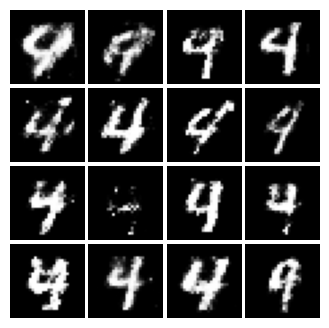

In [191]:
def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()



labels = torch.full((images.size(0),), 4, dtype=torch.long, device=device).to(device)  # batch of label 4
labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)
z = torch.randn(images.size(0), Z_dim).to(device)
samples = c_gen(z, labels_one_hot).detach().cpu().numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

"""
print(torch.max(F.softmax(model(image_new), dim=1),dim=1)[1])
print(image_new[0][0] == image_norm[0][0])
"""
"""
def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(train_loader))
X_real = images.float().to(device)
labels_one_hot = F.one_hot(labels.to(torch.int64), num_classes=10).float().to(device)
plot_digit(c_gen(X_real,labels_one_hot))

"""